## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images

The images for camera calibration are stored in the folder called camera_cal.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# objp = np.zeros((6*9,3), np.float32)
# objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

In [2]:
images

['camera_cal/calibration1.jpg',
 'camera_cal/calibration10.jpg',
 'camera_cal/calibration11.jpg',
 'camera_cal/calibration12.jpg',
 'camera_cal/calibration13.jpg',
 'camera_cal/calibration14.jpg',
 'camera_cal/calibration15.jpg',
 'camera_cal/calibration16.jpg',
 'camera_cal/calibration17.jpg',
 'camera_cal/calibration18.jpg',
 'camera_cal/calibration19.jpg',
 'camera_cal/calibration2.jpg',
 'camera_cal/calibration20.jpg',
 'camera_cal/calibration3.jpg',
 'camera_cal/calibration4.jpg',
 'camera_cal/calibration5.jpg',
 'camera_cal/calibration6.jpg',
 'camera_cal/calibration7.jpg',
 'camera_cal/calibration8.jpg',
 'camera_cal/calibration9.jpg']

In [3]:
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

## 2. Apply a distortion correction to raw images.

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # undist = np.copy(img)  # Delete this line
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    return dst,mtx,dist


OpenCV functions were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (calibration2.jpg).

The distortion matrix **(mtx)** is used to un-distort the calibration image. It can be seen in the undistorted image that the processing worked, as observed in the lack of a curvature in the top edge of the chessboard.

undistorting sample image:  camera_cal/calibration2.jpg


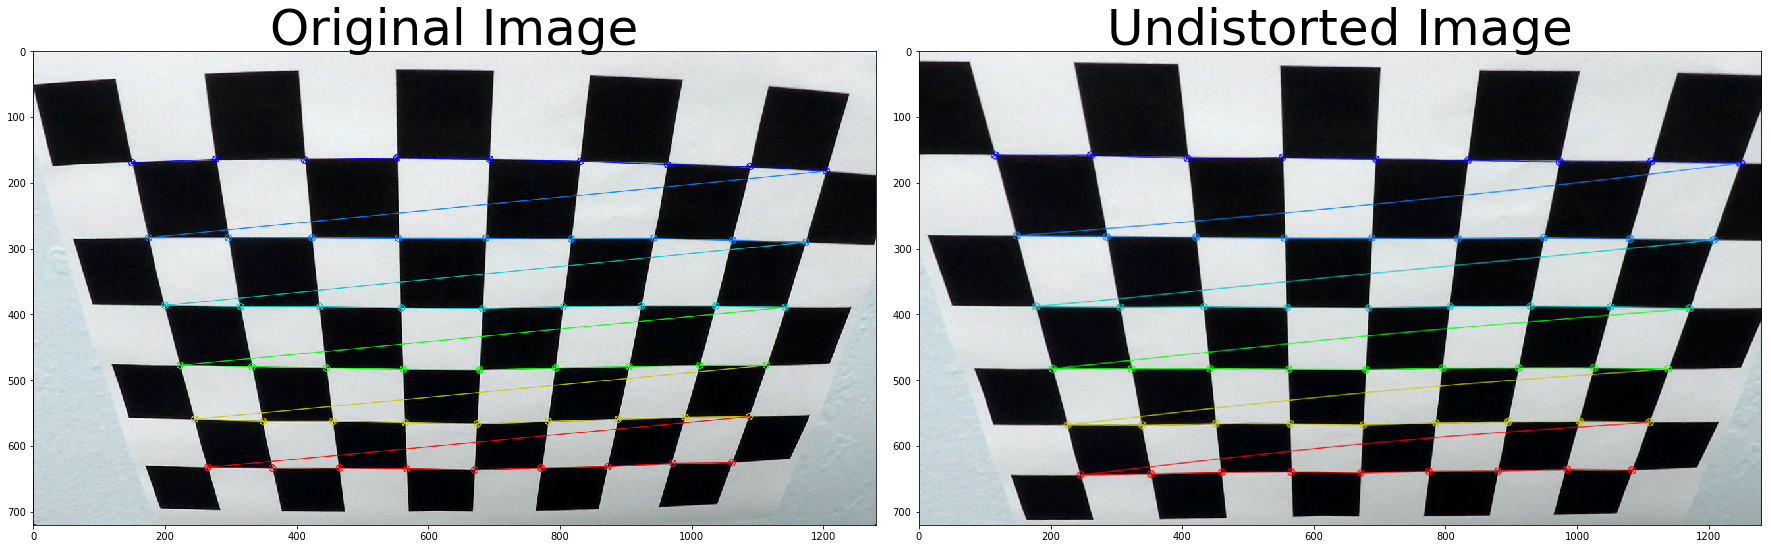

In [5]:
img = cv2.imread(images[11])
print('undistorting sample image: ',images[11])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

# If found, add object points, image points
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)
    img2 = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

undistorted,mtx,dist = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/distortion_correction_output.jpg',figsize=(1,1))

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

Described below is how I used color transforms, gradients or other methods to create a thresholded binary image. Provided is an example of a binary image result.

In [6]:
test_images = glob.glob('test_images/test*.jpg')
line_images = glob.glob('test_images/straight_lines*.jpg')
test_images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

In [156]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = cv2.GaussianBlur(img,(5,5),0)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    v_channel = hls[:,:,2]    
    
    # Explore gradients in other colors spaces / color channels to see what might work better
    # Sobel x
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobelx = cv2.GaussianBlur(sobelx,(3,3,),0)
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = sx_thresh[0]
    thresh_max = sx_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary = cv2.GaussianBlur(s_binary,(3,3,),0)
    
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary,color_binary    

**Provided below are examples of binary image result.**

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

The code for my perspective transform includes a function called warper(), which appears in lines 1 through 8 in the file example.py (examples/example.py) . The warper() function takes as inputs an image (img), as well as source (src) and destination (dst) points. I chose the hardcode the source and destination points in the following manner:



In [240]:
def warper(img, src=None,dst=None
#            src=np.float32([(545,485),
#                   (735,485), 
#                   (1065,695),
#                   (245,695) 
#                   ]), 
#            dst = np.float32([(450,0),
#                   (1200-450,0),
#                   (1200-450,720),
#                   (450,720)
#                   ])
          ):
#     img_size=img.shape
#     src = np.float32( \
#     [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100], \
#     [((img_size[0] / 6) - 10), img_size[1]], \
#     [(img_size[0] * 5 / 6) + 60, img_size[1]], \
#     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
#     dst = np.float32( \
#     [[(img_size[0] / 4), 0], \
#     [(img_size[0] / 4), img_size[1]], \
#     [(img_size[0] * 3 / 4), img_size[1]], \
#     [(img_size[0] * 3 / 4), 0]])
    src=np.float32([(580,460),
           (702,460), 
           (1124,720),
           (201,720) 
           ]) 
    dst = np.float32([(320,0),
           (960,0),
           (960,720),
           (320,720)
           ]) 

    # Compute and apply perpective transform
    # Return transform matrix
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    
    return warped,M,Minv


def undistort(img,mtx,dist):
    undistorted=cv2.undistort(img,mtx,dist,None,mtx)
    return undistorted

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


## 5. Detect lane pixels and fit to find the lane boundary.

In [241]:
def sliding_window(image=None,mtx=mtx,dist=dist, nwindows = 10,margin = 50,minpix = 50):
    undistorted = undistort(image, mtx,dist)
    img_size=undistorted.shape
    w=img_size[1]
    h=img_size[0]
    
    warped,perspective_M,return_M =  warper(undistorted)    
    binary_warped,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    

    # # Find the peak of the left and right halves of the histogram
    # # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img,return_M,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    

In [242]:
def get_curvature(ploty,lefty,righty,leftx,rightx,
                  xm_per_pix = 3.7/700,ym_per_pix = 30/720):
    #     lefty/righty is the actual pixel sample's y-value
    #     leftx/rightx is the actual pixel sample's x-value

    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #     print(left_curverad, 'm', right_curverad, 'm')

    return left_curverad,right_curverad

# def get_curvature(ploty,lefty,righty,leftx,rightx,
#                   xm_per_pix = 3.7/700,ym_per_pix = 30/720):
#     #     lefty/righty is the actual pixel sample's y-value
#     #     leftx/rightx is the actual pixel sample's x-value

#     y_eval = np.max(ploty)
#     # Define conversions in x and y from pixels space to meters
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension

#     # Fit new polynomials to x,y in world space
#     left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
#     right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

#     # Calculate the new radii of curvature
#     left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
#     right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
#     # Now our radius of curvature is in meters
#     #     print(left_curverad, 'm', right_curverad, 'm')
#     left_intercept=(left_fit_cr[0]*(ym_per_pix*y_eval)**2 + left_fit_cr[1]*(ym_per_pix*y_eval) + left_fit_cr[2]
#     right_intercept=(right_fit_cr[0]*(ym_per_pix*y_eval)**2 + right_fit_cr[1]*(ym_per_pix*y_eval) + right_fit_cr[2]

# #     lane_center = (left_fitx[-1] + right_fitx[-1])/2
#     lane_center = (right_intercept+left_intercept)/2
#     car_center = xm_per_pix*image.shape[1]/2
#     if(car_center<lane_center):
#         position='left of center'
#     elif(car_center>lane_center):
#         position ='right of center'
#     else:
#         position = 'center'
#     center_offset = abs(car_center-lane_center) 
#     print(left_fit_cr)
#     return center_offset,position    
    
#     return left_curverad,right_curverad,center_offset,center_position

def get_roc(line,xm_per_pix = 3.7/700,ym_per_pix = 30/720):
    #     lefty/righty is the actual pixel sample's y-value
    #     leftx/rightx is the actual pixel sample's x-value
    liney=line.ally
    linex=line.allx
    y_eval = np.max(line.ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    line_fit_cr = np.polyfit(liney*ym_per_pix, linex*xm_per_pix, 2)

    line_curverad = ((1 + (2*line_fit_cr[0]*y_eval*ym_per_pix + line_fit_cr[1])**2)**1.5) / np.absolute(2*line_fit_cr[0])
    # Now our radius of curvature is in meters
    #     print(left_curverad, 'm', right_curverad, 'm')

    return line_curverad


In [243]:
def return_line(orig_image,warped_image,left_fitx,right_fitx,ploty,return_M, left_curverad,right_curverad):
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    color_warp=cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, return_M, (orig_image.shape[1], orig_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
    
    
    new_img = np.copy(result)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of Curvature(L): ' + '{:04.2f}'.format(left_curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    text = 'Radius of Curvature(R): ' + '{:04.2f}'.format(right_curverad) + 'm'
    cv2.putText(new_img, text, (40,120), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    return new_img


In [244]:
def update_lanes(image=None,mtx=mtx,dist=dist
                 , nwindows = 9,margin = 80
                 ,minpix = 50, left_fit_previous=[]
                 ,right_fit_previous=[]):
    undistorted = undistort(image, mtx,dist)
    img_size=undistorted.shape
    w=img_size[1]
    h=img_size[0]
    
    warped,perspective_M,return_M =  warper(undistorted)    
#     binary_warped,stack_binary = pipeline(warped)
    binary_warped,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))
    #         pipeline_binary,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
#     margin = 100
#     margin=60
    left_lane_inds = ((nonzerox > (left_fit_previous[0]*(nonzeroy**2) + left_fit_previous[1]*nonzeroy + 
    left_fit_previous[2] - margin)) & (nonzerox < (left_fit_previous[0]*(nonzeroy**2) + 
    left_fit_previous[1]*nonzeroy + left_fit_previous[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_previous[0]*(nonzeroy**2) + right_fit_previous[1]*nonzeroy + 
    right_fit_previous[2] - margin)) & (nonzerox < (right_fit_previous[0]*(nonzeroy**2) + 
    right_fit_previous[1]*nonzeroy + right_fit_previous[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return out_img,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    


In [245]:
# Define a class to receive the characteristics of each line detection
import numpy as np
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.fitx = None
        self.ploty = None
        self.inverse_M = None
        
class Lane():
    def __init__(self):
        self.left_line = Line()
        self.right_line = Line()
        self.out_image = None
#         self.inverse_M = None
        self.mtx = None
        self.image=None
        self.detected=False


In [246]:
def update_lines(image=None,left_line=None,right_line=None):
    out_img,left_line.fitx,right_line.fitx, \
    left_line.ploty,left_line.allx, \
    left_line.ally,right_line.allx, \
    right_line.ally,left_line.current_fit, \
    right_line.current_fit = update_lanes( image, \
                                          left_fit_previous=left_line.current_fit, \
                                          right_fit_previous=right_line.current_fit) 
    return out_img,left_line, right_line

## Test on Videos

In [178]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

In [177]:
from numpy import random as rn

In [247]:
def extract_lines_sw(image=None,mtx=None,dist=None, nwindows=None ,margin=None ,minpix=None ):
    l_line=Line()
    r_line=Line()
    
    out_image,inverse_M,l_line.fitx,r_line.fitx,\
        l_line.ploty,l_line.allx,l_line.ally,\
        r_line.allx,r_line.ally,temp_lfit,\
        temp_rfit = sliding_window(image,mtx=mtx,dist=dist, nwindows = nwindows,margin = margin,minpix = minpix)
    r_line.ploty=l_line.ploty
    l_line.current_fit.append(temp_lfit)
    r_line.current_fit.append(temp_rfit)
    l_line.inverse_M = inverse_M
    r_line.inverse_M = inverse_M
    return out_image,l_line,r_line

def extract_lines_roi(image=None,mtx=mtx,dist=dist, nwindows = None,margin = None,minpix = None,left_line=None,right_line=None):
    l_line=Line()
    r_line=Line()
    
    out_image,l_line.fitx,r_line.fitx, l_line.ploty,l_line.allx, \
    l_line.ally,r_line.allx, r_line.ally,temp_lfit, \
    temp_rfit = update_lanes( image, left_fit_previous=left_line.current_fit, \
                             right_fit_previous=right_line.current_fit,mtx=mtx,\
                             dist=dist, nwindows = nwindows,margin = margin,minpix = minpix)         
        
    l_line.current_fit.append(temp_lfit)
    r_line.current_fit.append(temp_rfit)
    
    return out_image,l_line,r_line
#    out_img,return_M,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit



def extract_curvature(left_line=None,right_line=None):
    l_radius_of_curvature,r_radius_of_curvature = get_curvature(ploty=left_line.ploty, \
                                                 lefty=left_line.ally, \
                                                 righty=right_line.ally,\
                                                 leftx=left_line.allx,\
                                                 rightx=right_line.allx)
    return l_radius_of_curvature,r_radius_of_curvature


def extract_roc(left_line=None,right_line=None):
    l_radius_of_curvature=get_curvature(left_line)
    return l_radius_of_curvature,r_radius_of_curvature

def extract_offset(image,left_fitx=None,right_fitx=None,xm_per_pix = 3.7/700):
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    car_center = image.shape[1]/2
    if(car_center<lane_center):
        position='left of center'
    elif(car_center>lane_center):
        position ='right of center'
    else:
        position = 'center'
    center_offset = abs(car_center-lane_center) * xm_per_pix
    
    return center_offset,position
        

def return_line(orig_image,birds_eye_img,left_fitx,right_fitx,ploty,return_M, left_curverad,right_curverad):
    warp_zero = np.zeros_like(birds_eye_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    color_warp=cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, return_M, (orig_image.shape[1], orig_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
    
    
    new_img = np.copy(result)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of Curvature(L): ' + '{:04.2f}'.format(left_curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    text = 'Radius of Curvature(R): ' + '{:04.2f}'.format(right_curverad) + 'm'
    cv2.putText(new_img, text, (40,120), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    c_offset,c_pos=extract_offset(birds_eye_img,left_fitx=left_fitx,right_fitx=right_fitx)
    text = 'Vehicle is ' + '{:01.2f}'.format(c_offset) +'m ' + c_pos
    cv2.putText(new_img, text, (40,170), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    return new_img


def generate_lane_image(orig_image=None,birds_eye_img=None,left_line=Line(),right_line=Line()):
    new_img = return_line(orig_image=orig_image,birds_eye_img=birds_eye_img, \
                          left_fitx=left_line.fitx,right_fitx=right_line.fitx, \
                          ploty=left_line.ploty,return_M=left_line.inverse_M, \
                          left_curverad=left_line.radius_of_curvature,right_curverad=right_line.radius_of_curvature)
    return new_img



In [248]:
# def line_update(left_line=Line(),right_line()):
    
#     return line_input
    
def check_intercept(prev_l,prev_r,l_temp,r_temp):
    if ((abs(l_temp.fitx[-1] - r_temp.fitx[-1])<450) and (abs(l_temp.fitx[-1] - r_temp.fitx[-1])>250)):
#       return the current fit
        return l_temp,r_temp
    else:
#         return previous fit
        return prev_l,prev_r

    
def check_curvature(left_line=Line(),right_line=Line()):
    l,r=extract_curvature(left_line,right_line)
    if(left_line.radius_of_curvature is not None):
        if abs(l-left_line.radius_of_curvature)/left_line.radius_of_curvature>0.5:
            pass
        else:
            l=left_line.radius_of_curvature
    if(right_line.radius_of_curvature is not None):
        if abs(r-right_line.radius_of_curvature)/right_line.radius_of_curvature>0.5:
            pass
        else:
            r=right_line.radius_of_curvature    
            
    if((l-r)/r <0.5):
        left_line.best_fit=l
        right_line.best_fit=r
        left_line.detected=True
        right_line.detected=True
    else:
        left_line.detected=False
        right_line.detected=False
    return left_line,right_line
                     

In [114]:
    l_fit_x_int = lane_container.left_line.fitx[image.shape[0]-1]
    r_fit_x_int = lane_container.right_line.fitx[image.shape[0]-1]
    print(l_fit_x_int, r_fit_x_int, r_fit_x_int - l_fit_x_int)
    
    if ((r_fit_x_int - l_fit_x_int)<450.0 ) and ((r_fit_x_int - l_fit_x_int)>250.0):
        
#         if(abs(R-R0)/R0>0.5)
        if((lane_container.left_line.radius_of_curvature-lane_container.right_line.radius_of_curvature)/ \
           lane_container.right_line.radius_of_curvature <0.5):
#        abs(R-R0)/R0  # R = current radius of curvature
            lane_container.left_line.best_fit=lane_container.left_line.current_fit
            lane_container.right_line.best_fit=lane_container.right_line.current_fit
            lane_container.detected=True
        else:
            lane_container.out_image=image
            lane_container.detected=False  

(720,)
(720,)
(720,)


TypeError: non-empty format string passed to object.__format__

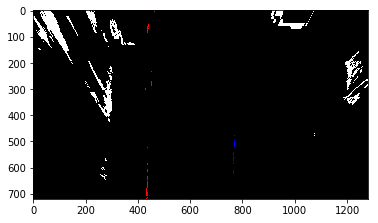

In [235]:
temp_img = mpimg.imread(test_images[4])
prev_l=Line()
prev_r=Line()
# checkpoint the previous lines
prev_l=l_temp
prev_r=r_temp
print(l_temp.ploty.shape)
print(r_temp.ploty.shape)
print(prev_r.ploty.shape)

out_temp,l_temp,r_temp = extract_lines_sw(image=temp_img,mtx=mtx,dist=dist, nwindows=9,margin=50 ,minpix=50 )
plt.imshow(out_temp)

# sanity check the distance between intercept

#     l_temp=prev_l
#     r_temp=prev_r
# if ((abs(l_temp.fitx[-1] - r_temp.fitx[-1])<450) and (abs(l_temp.fitx[-1] - r_temp.fitx[-1])>250)):
#     pass
# else:
#     l_temp=prev_l
#     r_temp=prev_r
l_temp,r_temp=check_intercept(prev_l=prev_l,prev_r=prev_r,l_temp=l_temp,r_temp=r_temp)


l_temp,r_temp=check_curvature(left_line=l_temp,right_line=r_temp)
# l_temp.radius_of_curvature = l
# r_temp.radius_of_curvature = r

line_update()
new_img=generate_lane_image(orig_image=temp_img,birds_eye_img=out_temp,left_line=l_temp,right_line=r_temp)
plt.figure()
plt.imshow(new_img)

In [117]:
temp_img.shape[0]

720

In [249]:
lane_container=Lane()
# lane_container.sliding_window(image)
# lane_container.sliding_window(mpimg.imread(line_images[0]))
def process_image(image):
    
    try:
        if(l_temp is not None):
            prev_l=l_temp
            prev_r=r_temp
            
        
        out_temp,l_temp,r_temp = extract_lines_roi(image=image,mtx=mtx,dist=dist, nwindows=9,margin=50 ,minpix=50 )
    # plt.imshow(out_temp)
        l_temp,r_temp=check_intercept(prev_l=prev_l,prev_r=prev_r,l_temp=l_temp,r_temp=r_temp)

        
#         l,r=extract_curvature(l_temp,r_temp)
#         l_temp.radius_of_curvature = l
#         r_temp.radius_of_curvature = r
        l_temp,r_temp=check_curvature(left_line=l_temp,right_line=r_temp)

    #     line_update()
        new_img=generate_lane_image(orig_image=image,birds_eye_img=out_temp,left_line=l_temp,right_line=r_temp)

    except:
        try:
            out_temp,l_temp,r_temp = extract_lines_sw(image=image,mtx=mtx,dist=dist, nwindows=9,margin=50 ,minpix=50 )
        # plt.imshow(out_temp)

            l,r=extract_curvature(l_temp,r_temp)
            l_temp.radius_of_curvature = l
            r_temp.radius_of_curvature = r

        #     line_update()
            new_img=generate_lane_image(orig_image=image,birds_eye_img=out_temp,left_line=l_temp,right_line=r_temp)
        except:
            new_img=image
        else:
            pass
    else:
        new_img=image
        
    return new_img

In [250]:
sample_output = 'first_iter5.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)

[MoviePy] >>>> Building video first_iter5.mp4
[MoviePy] Writing video first_iter5.mp4


100%|█████████▉| 1260/1261 [02:29<00:00,  9.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: first_iter5.mp4 

CPU times: user 3min 16s, sys: 24.6 s, total: 3min 41s
Wall time: 2min 29s
